## Notebook - Chapter06_Reservoir Engineering

In [45]:

# importing basic libraries
import pandas as pd
from pandas import DataFrame
import numpy as np

import requests
import random
import xlrd
import csv
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# visualization/plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns
import matplotlib.pyplot as plt
# setting to default parameters
plt.rcParams.update(plt.rcParamsDefault)

# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)

sns.set_style("white")
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# matplotlib settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-v0_8-white')
mpl.rcParams["figure.figsize"] = (12, 8)
mpl.rcParams["axes.grid"] = False

In [10]:
# setting seed for model reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [11]:
# ARPS Decline Curve Analysis

def pre_process(df, column):
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.info()
    print(df.columns)
    # descriptive statistics
    df.describe().T
    df.head(15)
    df.nunique()
    df.dtypes
    df.shape
    # filtering
    df.dropna(inplace=True)
    # drop rows where oil rate is 0
    df = df[(df[column].notnull()) & (df[column] > 0)]
    return df

def plot_production_rate(df):
    '''Plot decline curve using production rates'''
    sns.lineplot(x = df['ReportDate'], y = df['oil_rate'], markers=True, dashes=False,
                 label="Oil Production",color='blue', linewidth=1.5)
    plt.title('Decline Curve', fontweight='bold', fontsize = 20)
    plt.xlabel('Time', fontweight='bold', fontsize = 15)
    plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
    plt.show()

def decline_curve(curve_type, q_i):
    if curve_type == "exponential":

        def exponential_decline(T, d):
            return q_i * np.exp(-d * T)
        return exponential_decline

    elif curve_type == "hyperbolic":

        def hyperbolic_decline(T, d_i, b):
            return q_i / np.power((1 + b * d_i * T), 1.0 / b)
        return hyperbolic_decline

    elif curve_type == "harmonic":

        def parabolic_decline(T, d_i):
            return q_i / (1 + d_i * T)
        return parabolic_decline

    else:
        raise "Unknown Decline Curve!"


def L2_norm(Q, Q_obs):
    return np.sum(np.power(np.subtract(Q, Q_obs), 2))

In [5]:

# نصب gdown (در صورت لزوم)
#!pip install gdown --quiet

import gdown

gdown.download(url=' https://drive.google.com/uc?id=1TvQvO7UQTu7TCzhrdEiQoahJbZHrXcyG', output='train_prod.csv', quiet=False)
gdown.download(url=' https://drive.google.com/uc?id=1TqgmmkDpSSvZrhUjnoas7NE7Z3MtqMnA', output='test_prod.csv', quiet=False)


train_prod = pd.read_csv('train_prod.csv')
test_prod = pd.read_csv('test_prod.csv')

# تست
print("Train data shape:", train_prod.shape)
print("Test data shape:", test_prod.shape)

Downloading...
From (original):  https://drive.google.com/uc?id=1TvQvO7UQTu7TCzhrdEiQoahJbZHrXcyG
From (redirected): https://drive.google.com/uc?id=1TvQvO7UQTu7TCzhrdEiQoahJbZHrXcyG&confirm=t&uuid=767238c3-b0f7-4948-83d4-0840114fa2df
To: /content/train_prod.csv
100%|██████████| 143M/143M [00:03<00:00, 41.8MB/s]
Downloading...
From:  https://drive.google.com/uc?id=1TqgmmkDpSSvZrhUjnoas7NE7Z3MtqMnA
To: /content/test_prod.csv
100%|██████████| 45.0M/45.0M [00:01<00:00, 23.7MB/s]


Train data shape: (684415, 22)
Test data shape: (215017, 22)


In [14]:
# reading train and test data

train_prod = pd.read_csv('train_prod.csv')
test_prod = pd.read_csv("test_prod.csv")

# Basic Processing and data exploration
train_prod = pre_process(train_prod, 'Oil')
test_prod = pre_process(test_prod, 'Oil')

# convert time to datetime and set as dataframe index
train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])

#bakken_data.set_index("ReportDate", inplace=True)
train_prod["First_Prod_Date"] = train_prod.groupby("API_WELLNO")["ReportDate"].transform('min')
train_prod["Days_Online"] = (train_prod["ReportDate"] - train_prod["First_Prod_Date"]).dt.days

# find the top 10 wells with highest production (sum)
grouped_data = train_prod.groupby(['API_WELLNO'])[['Oil']].sum()
grouped_data = grouped_data.sort_values(by=['Oil'])
grouped_data = grouped_data.nlargest(10, 'Oil').reset_index()

example_wells = grouped_data['API_WELLNO'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684415 entries, 0 to 684414
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ReportDate  684415 non-null  object 
 1   API_WELLNO  684415 non-null  float64
 2   FileNo      684415 non-null  float64
 3   Company     684415 non-null  object 
 4   WellName    684415 non-null  object 
 5   Quarter     684415 non-null  object 
 6   Section     684415 non-null  float64
 7   Township    684415 non-null  float64
 8   Range       684415 non-null  float64
 9   County      684415 non-null  object 
 10  FieldName   684415 non-null  object 
 11  Pool        684415 non-null  object 
 12  Oil         678599 non-null  float64
 13  Wtr         678599 non-null  float64
 14  Days        678599 non-null  float64
 15  Runs        684415 non-null  float64
 16  Gas         678599 non-null  float64
 17  GasSold     684415 non-null  float64
 18  Flared      678599 non-null  float64
 19  La

[3.30250262e+13 3.30530592e+13 3.30530565e+13 3.30530741e+13
 3.30530578e+13 3.30530592e+13 3.30530592e+13 3.30530592e+13
 3.30250218e+13 3.30550014e+13]
API: [33053059210000, 33025021780000]


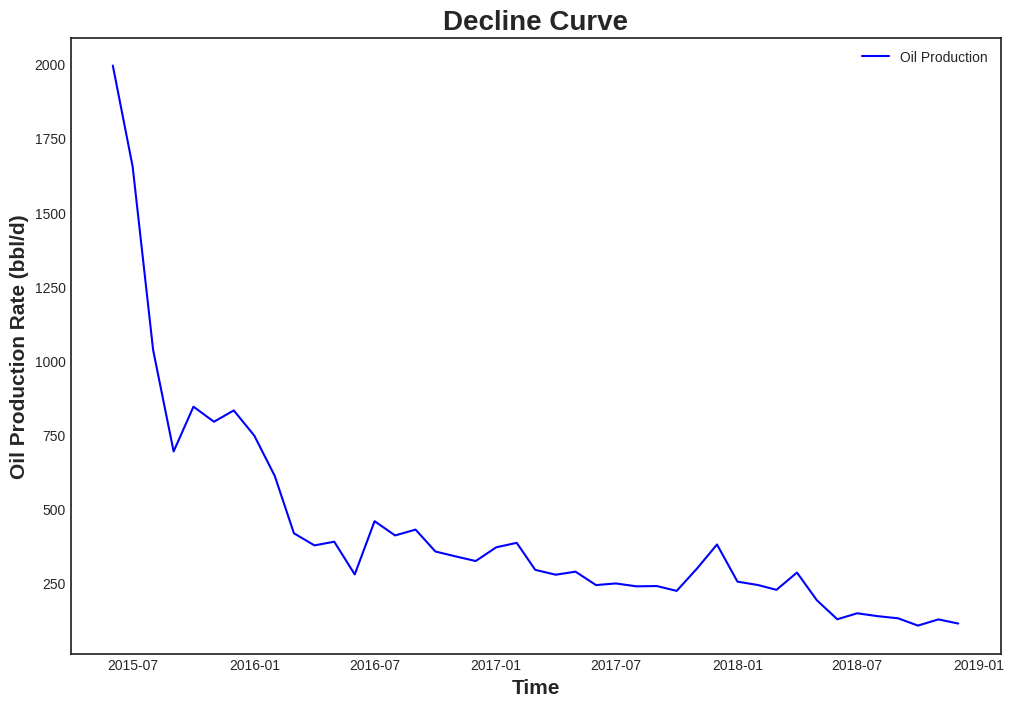

In [15]:
print (example_wells)
demo_well = [33053059210000, 33025021780000]

print('API:', demo_well)
df_temp = train_prod[train_prod['API_WELLNO'] == demo_well[1]]
df_temp["oil_rate"] = df_temp["Oil"] / df_temp["Days"]
df_temp['date_delta'] = (df_temp['ReportDate'] - df_temp['ReportDate'].min())/np.timedelta64(1,'D')
plot_production_rate(df_temp)

In [16]:
df_temp = df_temp[['date_delta', 'oil_rate']]
data = df_temp.to_numpy()
# T is number of days of production - cumulative
# q is production rate
T_train, q = data.T
print(T_train)
print(q)

[   0.   30.   61.   92.  122.  153.  183.  214.  245.  274.  305.  335.
  366.  396.  427.  458.  488.  519.  549.  580.  611.  639.  670.  700.
  731.  761.  792.  823.  853.  884.  914.  945.  976. 1004. 1035. 1065.
 1096. 1126. 1157. 1188. 1218. 1249. 1279.]
[1994.9375     1654.4516129  1035.4         693.36666667  844.4516129
  793.62068966  831.80645161  746.90322581  610.75862069  417.38095238
  376.63333333  388.96774194  278.68965517  458.23076923  410.12903226
  429.86666667  355.96774194  339.26666667  323.80769231  370.125
  385.21428571  294.12903226  277.66666667  287.93548387  242.73333333
  248.22580645  238.48387097  239.4137931   223.16129032  299.1
  379.57142857  254.24137931  242.88461538  226.68965517  284.86206897
  191.76666667  127.36666667  147.5483871   137.90322581  130.6
  106.09677419  126.96551724  112.93548387]


In [17]:
# Assumption - determine qi from max value of first 3 months of production
df_initial_period = df_temp.head(3)
qi = df_initial_period['oil_rate'].max()

exp_decline = decline_curve("exponential", qi)
hyp_decline = decline_curve("hyperbolic", qi)
har_decline = decline_curve("harmonic", qi)

popt_exp, pcov_exp = curve_fit(exp_decline, T_train, q, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T_train, q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T_train, q, method="trf")

print("L2 Norm of exponential decline: ", L2_norm(exp_decline(T_train, popt_exp[0]), q))
print("L2 Norm of hyperbolic decline decline: ",L2_norm(hyp_decline(T_train, popt_hyp[0], popt_hyp[1]), q))
print("L2 Norm of harmonic decline decline: ", L2_norm(har_decline(T_train, popt_har[0]), q))

L2 Norm of exponential decline:  10167505.41462357
L2 Norm of hyperbolic decline decline:  309675.9298070103
L2 Norm of harmonic decline decline:  361356.90904455684


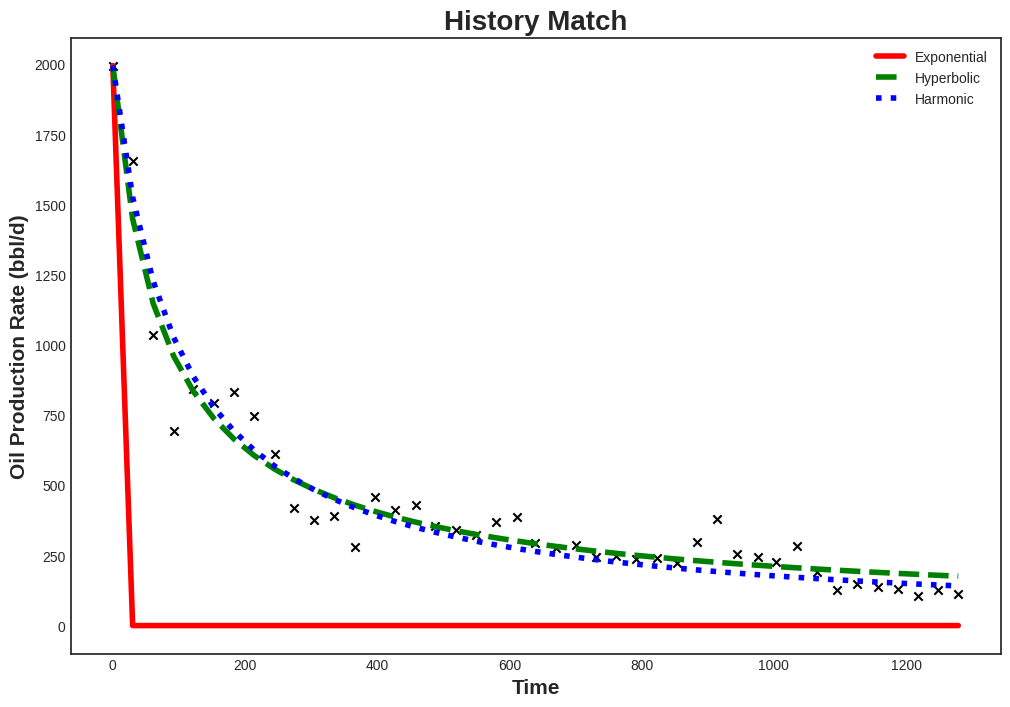

In [18]:
# Predict
plt.scatter(T_train, q, color="black", marker="x", alpha=1)
pred_exp = exp_decline(T_train, popt_exp[0])
pred_hyp = hyp_decline(T_train, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_train, popt_har[0])
plt.plot(T_train, pred_exp, color="red", label="Exponential", linewidth = 4)
plt.plot(T_train, pred_hyp, color="green", label="Hyperbolic", linestyle="--", linewidth = 4)
plt.plot(T_train, pred_har, color="blue", label="Harmonic", linestyle = ':', linewidth = 4)
plt.title('History Match', fontweight='bold', fontsize = 20)
plt.xlabel('Time', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
plt.legend(loc='best')
plt.show()

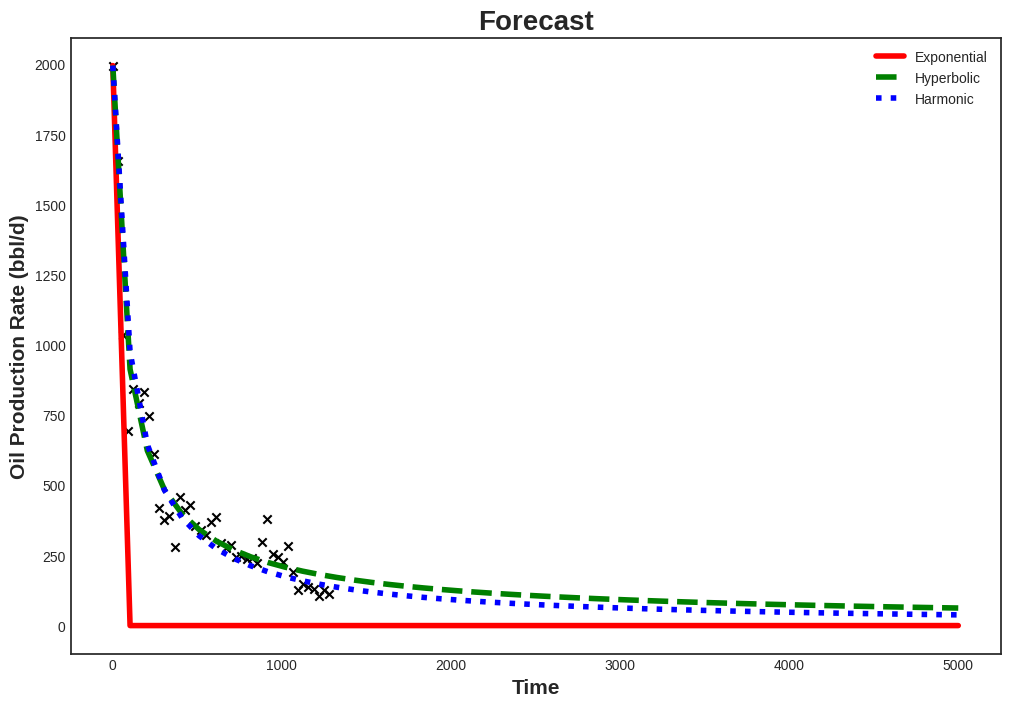

In [19]:
# Forecast
max_time_forecast = 5000
T_pred = np.linspace(min(T_train), max_time_forecast)
plt.scatter(T_train, q, color="black", marker="x", alpha=1)
pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])
plt.plot(T_pred, pred_exp, color="red", label="Exponential", linewidth = 4)
plt.plot(T_pred, pred_hyp, color="green", label="Hyperbolic", linestyle="--", linewidth = 4)
plt.plot(T_pred, pred_har, color="blue", label="Harmonic", linestyle = ':', linewidth = 4)
plt.title('Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
plt.legend(loc='best')
plt.show()

In [20]:
# validation procedure

print('API:', demo_well[1])
df_temp_test = test_prod[test_prod['API_WELLNO'] == demo_well[1]]
df_temp_test["oil_rate"] = df_temp_test["Oil"] / df_temp_test["Days"]
df_temp_test['date_delta'] = (df_temp_test['ReportDate'] - df_temp_test['ReportDate'].min())  / np.timedelta64(1,'D')
print(df_temp_test)
df_temp_test = df_temp_test[['date_delta', 'oil_rate']]
data_test = df_temp_test.to_numpy()
# T is number of days of production - cumulative
# q is production rate
T_test, q_test = data_test.T

#T_test = np.concatenate(T_train, T)
print(T_test)
print(q_test)

API: 33025021780000
       ReportDate        API_WELLNO   FileNo  \
9237   2019-01-01 33025021780000.00 25736.00   
26666  2019-02-01 33025021780000.00 25736.00   
44161  2019-03-01 33025021780000.00 25736.00   
61730  2019-04-01 33025021780000.00 25736.00   
79421  2019-05-01 33025021780000.00 25736.00   
97225  2019-06-01 33025021780000.00 25736.00   
115149 2019-07-01 33025021780000.00 25736.00   
133202 2019-08-01 33025021780000.00 25736.00   
151359 2019-09-01 33025021780000.00 25736.00   
169616 2019-10-01 33025021780000.00 25736.00   
187967 2019-11-01 33025021780000.00 25736.00   

                                   Company              WellName Quarter  \
9237    ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
26666   ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
44161   ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
61730   ENERPLUS RESOURCES USA CORPORATION  SNOW  149-93-07A-12H    SENE   
79421   ENERPLUS RESOUR

In [21]:
time = pd.date_range(start='6/1/2015', periods= 54, freq='MS')
time
T_Test2 = T_train[-1] + T_test
len(T_train)
pred_hyp =  hyp_decline(T_train, popt_hyp[0], popt_hyp[1])
pred_hyp2 = hyp_decline(T_Test2, popt_hyp[0], popt_hyp[1])
print(pred_hyp)
print(pred_hyp2)
# forecast
q_orig = np.append(q, q_test)
forecast = np.concatenate([pred_hyp, pred_hyp2])

[1994.9375     1448.62576796 1148.04118283  960.09163565  833.84616241
  737.35543199  665.22003716  605.68592895  557.07659257  518.96359759
  484.25039057  455.3220305   429.27541854  407.09626656  386.75357091
  368.59446648  352.77430862  337.96976613  324.92783225  312.60103436
  301.29356499  291.85138729  282.15313238  273.44126571  265.05961127
  257.48694419  250.16247665  243.29749669  237.05044018  230.96768984
  225.41034932  219.97896687  214.83776698  210.42390577  205.77211495
  201.48820459  197.26992985  193.3750533   189.5303175   185.85597128
  182.4515345   179.07983009  175.94945389]
[175.94945389 172.84316894 170.14306192 167.26370156 164.5810902
 161.91023261 159.41799886 156.93297715 154.53476677 152.29219405
 150.05154914]


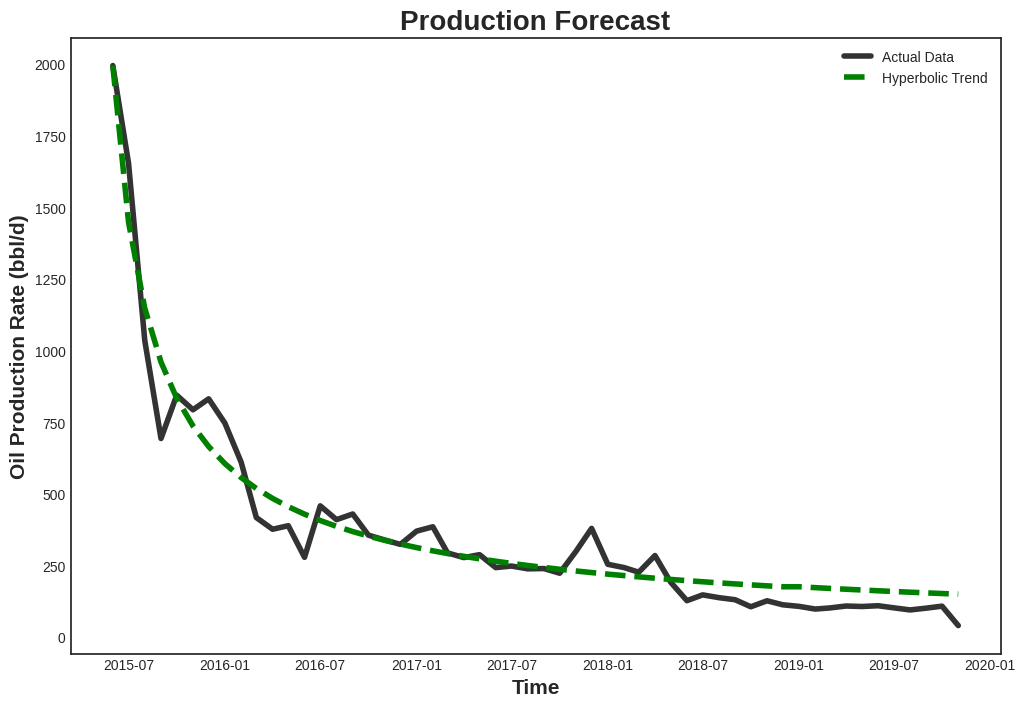

In [22]:
# hyperbolic forecast - plot
plt.plot(time, q_orig, color="black", alpha = 0.8, label='Actual Data', linewidth = 4)
plt.plot(time, forecast, color="green", label="Hyperbolic Trend", linewidth = 4, linestyle="--")
plt.title('Production Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production Rate (bbl/d)', fontweight='bold', fontsize = 15)
plt.legend(loc='best')
plt.show()

In [23]:
rmse = sqrt(mean_squared_error(q_orig, forecast))
print("RMSE - Hyperbolic Method:", rmse)

RMSE - Hyperbolic Method: 81.41922170670097


## ARIMA MODEL BASED DCA

In [25]:
def plot_production_series(series):
    plt.figure(figsize=(10, 6))
    plt.plot(series, color = 'blue')
    plt.title("Oil Production Decline")
    plt.xlabel("Year")
    plt.ylabel("Production Rate (bbls/d)")
    plt.show()

In [26]:
# data
train_prod = pd.read_csv('train_prod.csv')
test_prod = pd.read_csv("test_prod.csv")
print('Training Data:\n', train_prod.head(10))
print('\n')
print('Test Data:\n', train_prod.head(10))

Training Data:
    Unnamed: 0  ReportDate        API_WELLNO   FileNo  \
0           0  2015-05-01 33053043310000.00 23615.00   
1           1  2015-05-01 33053038990000.00 22021.00   
2           2  2015-05-01 33053048330000.00 25091.00   
3           3  2015-05-01 33053050010000.00 25645.00   
4           4  2015-05-01 33053048340000.00 25092.00   
5           5  2015-05-01 33053050000000.00 25644.00   
6           6  2015-05-01 33053039010000.00 22023.00   
7           7  2015-05-01 33053042390000.00 23319.00   
8           8  2015-05-01 33053042400000.00 23320.00   
9           9  2015-05-01 33053042380000.00 23302.00   

                       Company                  WellName Quarter  Section  \
0  MUREX PETROLEUM CORPORATION   AMBER ELIZABETH  36-25H    SESW    36.00   
1         STATOIL OIL & GAS LP          BILL  14-23 2TFH    SWSW    11.00   
2         STATOIL OIL & GAS LP            BILL  14-23 3H    NWNE    14.00   
3         STATOIL OIL & GAS LP          BILL  14-23 4TFH   

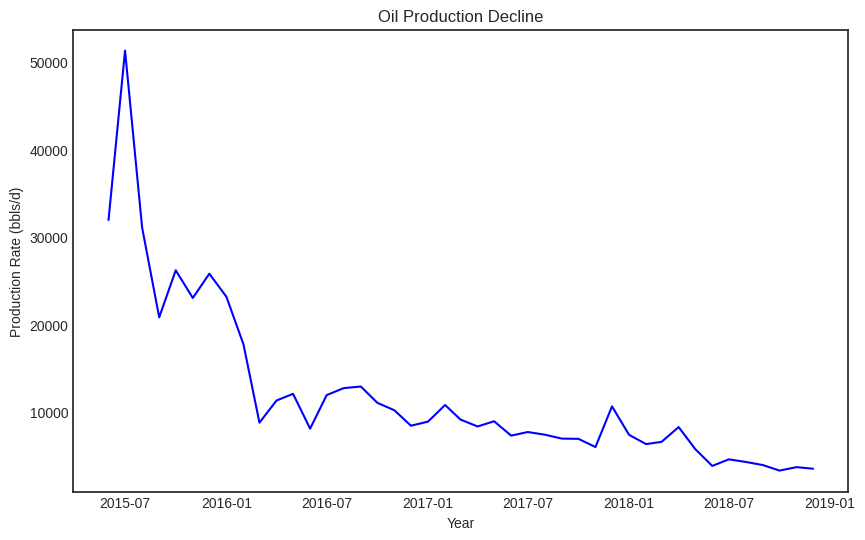

In [27]:
# Preprocessing on train data
# well selection for demo - time series
train_prod = train_prod[train_prod["API_WELLNO"] == 33025021780000.0]
train_prod.drop("Unnamed: 0", axis=1, inplace=True)
train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
train_prod.set_index("ReportDate", inplace=True)
train_prod.nunique()

# converting data from dataframe to series - oil production
timeseries_train= train_prod["Oil"]
timeseries_train.head()
plot_production_series(timeseries_train)

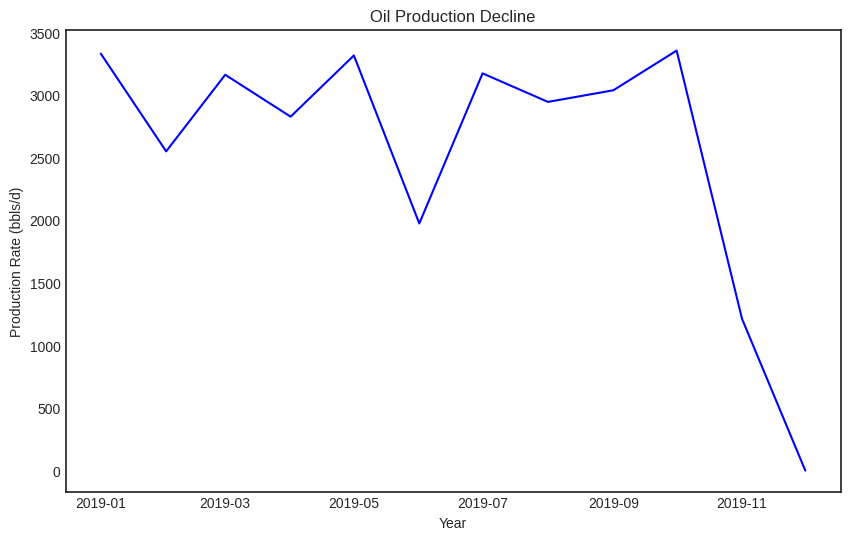

In [28]:
# Preprocessing on test data
# well selection for demo - time series
test_prod = test_prod[test_prod["API_WELLNO"] == 33025021780000.0]
test_prod.drop("Unnamed: 0", axis=1, inplace=True)
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])
test_prod.set_index("ReportDate", inplace=True)
test_prod.nunique()

# time series is production volumes and not flow rates
timeseries_test = test_prod["Oil"]
timeseries_test.head()
plot_production_series(timeseries_test)

In [29]:
# ADF - Augmented Dickey-Fuller unit root test - to test stationarity
print("p-value:", adfuller(timeseries_train.dropna())[1])

p-value: 0.812170915513829


In [30]:
# Perform Dickey-Fuller test:
def dickey_ful_test(series):
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(series, autolag="AIC")
    df_output = pd.Series(df_test[0:4],index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

In [31]:
def stationary_test_plot(metric, data_series, method):
    plt.figure(figsize=(10, 6))
    orig = plt.plot(data_series, label="Original", color = 'blue')
    metric = plt.plot(metric, label= method, color ='red')
    plt.legend(loc="best")
    plt.title(method)
    plt.xlabel('Time (yyyy-mm)')
    plt.ylabel('Oil Production (bbls)')
    plt.show()

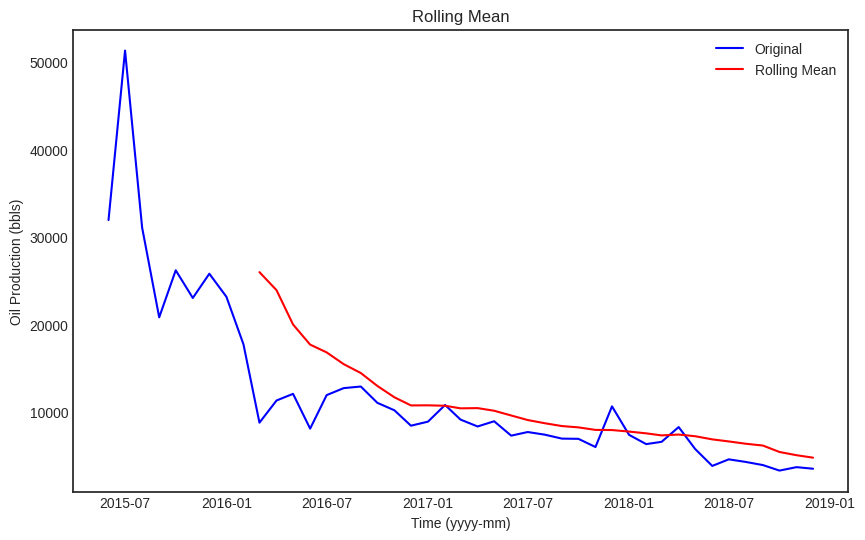

Results of Dickey-Fuller Test:
Test Statistic                -0.82
p-value                        0.81
#Lags Used                     9.00
Number of Observations Used   33.00
Critical Value (1%)           -3.65
Critical Value (5%)           -2.95
Critical Value (10%)          -2.62
dtype: float64


In [32]:

def stationary_test(data_series, method):
    rolling_mean = data_series.rolling(10).mean()
    stationary_test_plot(rolling_mean, data_series, method)
    dickey_ful_test(data_series)

# test if the time series data is stationary or not
stationary_test(timeseries_train, "Rolling Mean")

In [33]:
def plot_time_series(y_axis, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_axis, label = y_label, color = 'blue')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

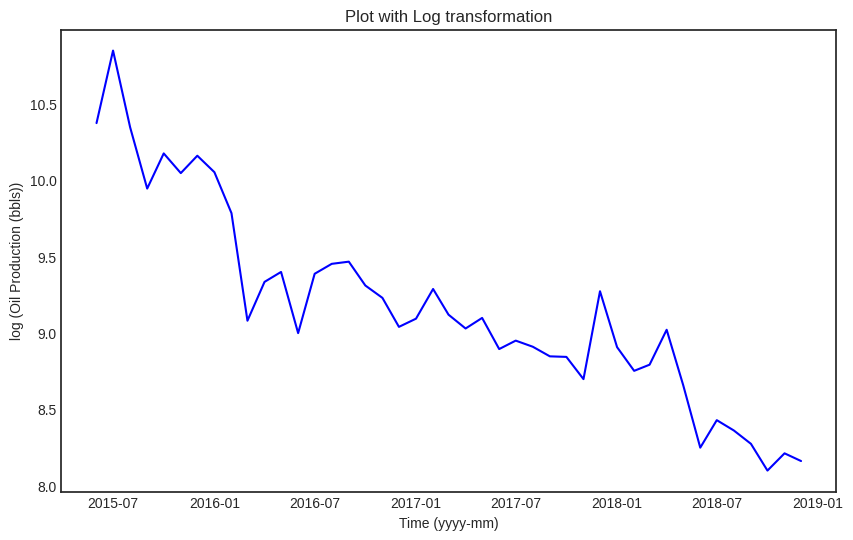

In [34]:
# y axis transformation - log(data)
ts_log = np.log(timeseries_train)
plot_time_series(ts_log, "Time (yyyy-mm)", "log (Oil Production (bbls))", "Plot with Log transformation")

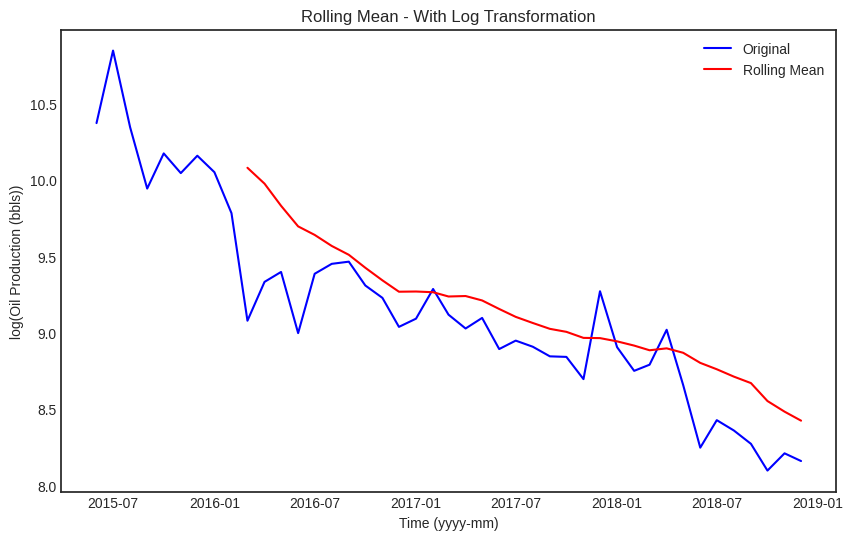

In [35]:
# rolling mean estimation and plot
rolling_mean_log = ts_log.rolling(10).mean()

plt.figure(figsize=(10, 6))
orig = plt.plot(ts_log, label="Original", color = 'blue')
mean = plt.plot(rolling_mean_log, label="Rolling Mean", color ='red')
plt.title("Rolling Mean - With Log Transformation")
plt.xlabel('Time (yyyy-mm)')
plt.ylabel('log(Oil Production (bbls))')
plt.legend(loc="best")
plt.show()

In [36]:
# plot of difference between log(data) and moving average
diff_log_rolmean = ts_log - rolling_mean_log
diff_log_rolmean.dropna(inplace=True)

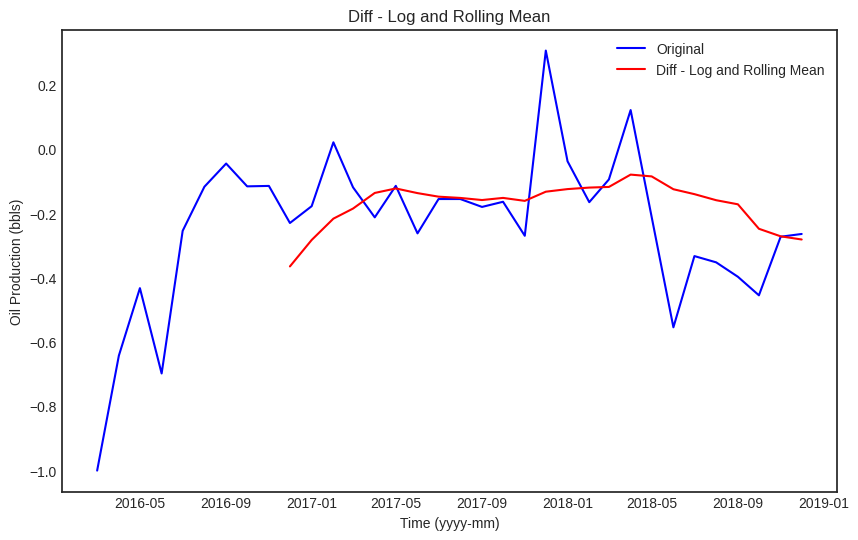

Results of Dickey-Fuller Test:
Test Statistic                -1.36
p-value                        0.60
#Lags Used                     7.00
Number of Observations Used   26.00
Critical Value (1%)           -3.71
Critical Value (5%)           -2.98
Critical Value (10%)          -2.63
dtype: float64


In [37]:
stationary_test(diff_log_rolmean, "Diff - Log and Rolling Mean")

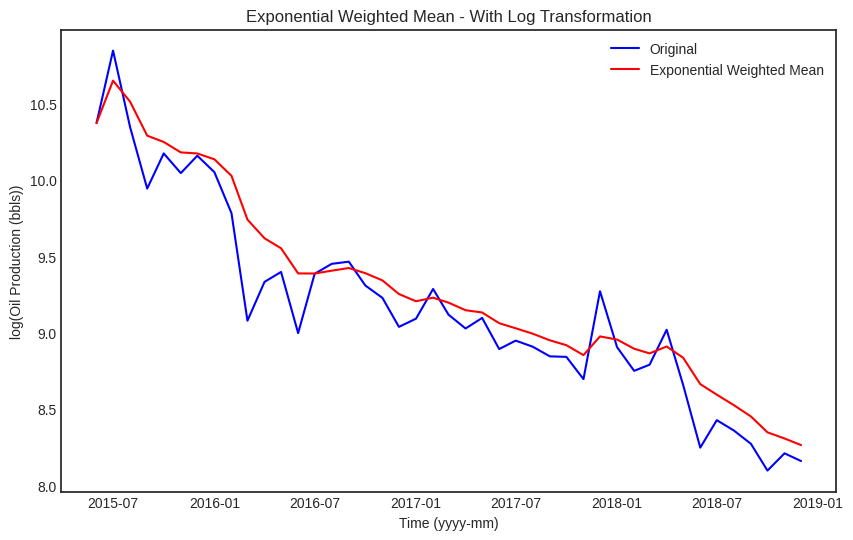

In [38]:
# exponential weighted calculations
weighted_avg_exp = ts_log.ewm(halflife=2).mean()
plt.figure(figsize=(10, 6))

orig = plt.plot(ts_log, label="Original", color = 'blue')
mean = plt.plot(weighted_avg_exp, label="Exponential Weighted Mean", color ='red')
plt.title("Exponential Weighted Mean - With Log Transformation")
plt.xlabel('Time (yyyy-mm)')
plt.ylabel('log(Oil Production (bbls))')
plt.legend(loc="best")
plt.show()

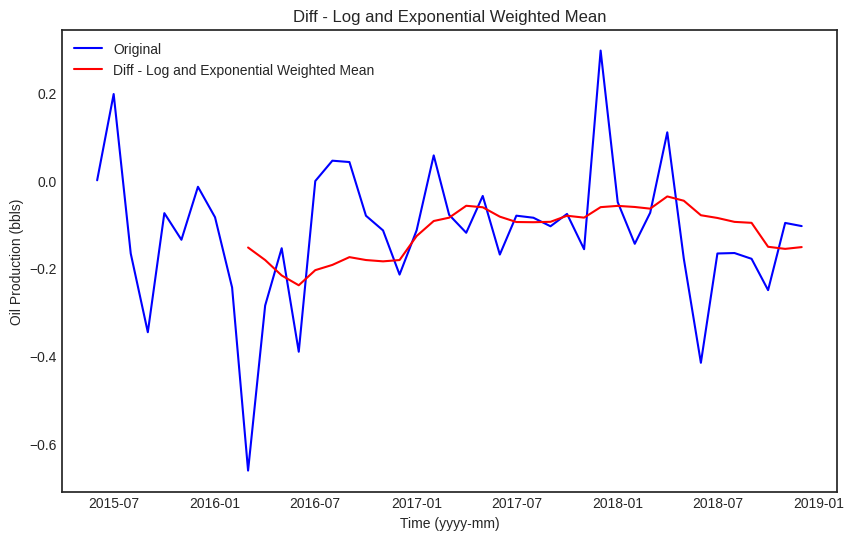

Results of Dickey-Fuller Test:
Test Statistic                -4.95
p-value                        0.00
#Lags Used                     0.00
Number of Observations Used   42.00
Critical Value (1%)           -3.60
Critical Value (5%)           -2.93
Critical Value (10%)          -2.60
dtype: float64


In [39]:
diff_log_ewm = ts_log - weighted_avg_exp
stationary_test(diff_log_ewm, "Diff - Log and Exponential Weighted Mean")

In [40]:
# First Order differencing - n this technique, we take the difference of the observation at a particular instant with
# that at the previous instant. This mostly works well in improving stationarity

# Differencing can help stabilize the mean of the time series by removing changes in the level of a time series,
# and so eliminating (or reducing) trend and seasonality
# https://machinelearningmastery.com/difference-time-series-dataset-python/

first_order_diff = ts_log - ts_log.shift()

<Figure size 1000x600 with 0 Axes>

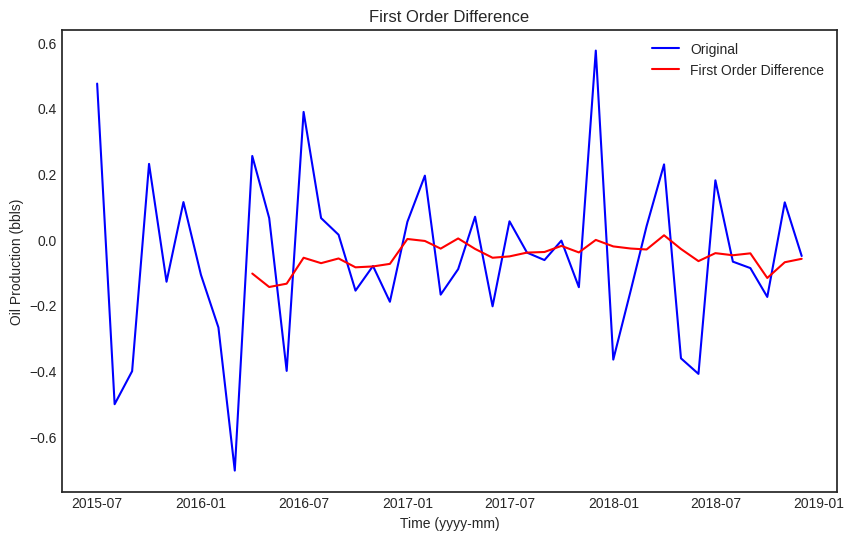

Results of Dickey-Fuller Test:
Test Statistic                -7.22
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   40.00
Critical Value (1%)           -3.61
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [41]:
first_order_diff.dropna(inplace=True)
plt.figure(figsize=(10, 6))
stationary_test(first_order_diff, "First Order Difference")

In [42]:
ts_log_diff_active = first_order_diff

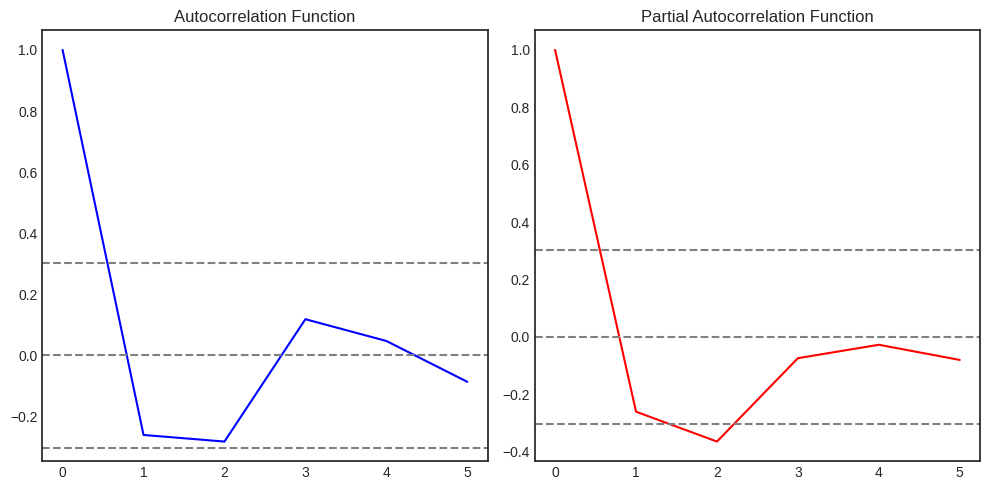

In [71]:

lag_acf = acf(ts_log_diff_active, nlags=5)
lag_pacf = pacf(ts_log_diff_active, nlags=5, method="ols")
plt.figure(figsize=(10, 5))

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf, color = 'blue')
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf, color = 'red')
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(ts_log_diff_active)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()
plt.show()

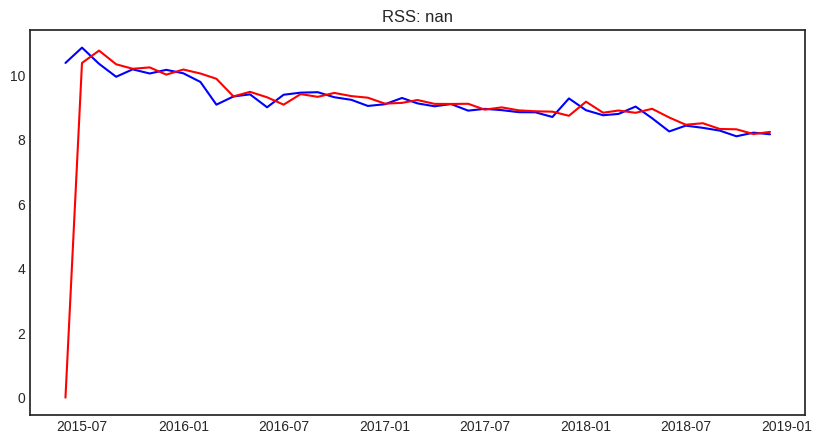

In [79]:
# Auto-Regressive Model (p=2, d=1, q=0)
model_AR = ARIMA(ts_log, order=(2, 1, 0))
results_ARIMA_AR = model_AR.fit()
plt.figure(figsize=(10, 5))
plt.plot(ts_log, color = 'blue')
plt.plot(results_ARIMA_AR.fittedvalues, color="red")
plt.title("RSS: %.3f" % sum((results_ARIMA_AR.fittedvalues - first_order_diff) ** 2))
plt.show()

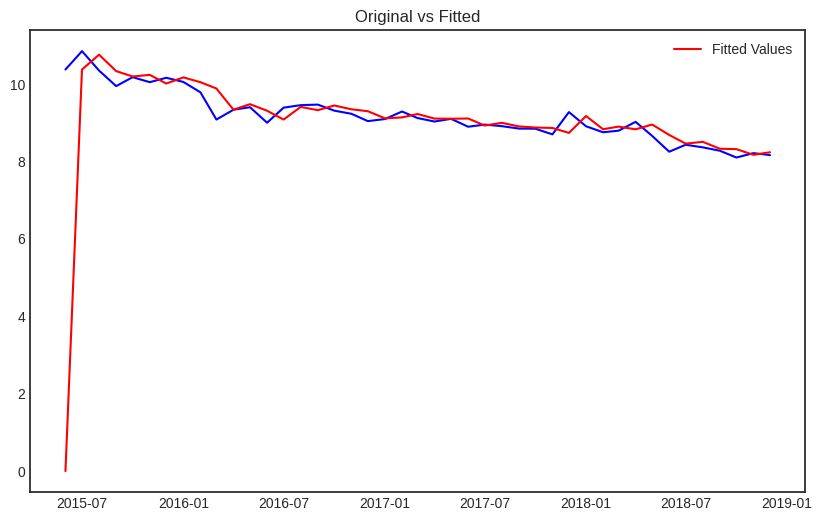

In [78]:

# رسم مقادیر اولیه
plt.figure(figsize=(10, 6))


plt.plot(ts_log, color = 'blue')
# رسم fittedvalues با شیفت مناسب
plt.plot(results_ARIMA_AR.fittedvalues, color='red', label='Fitted Values')

plt.title('Original vs Fitted')
plt.legend()
plt.show()

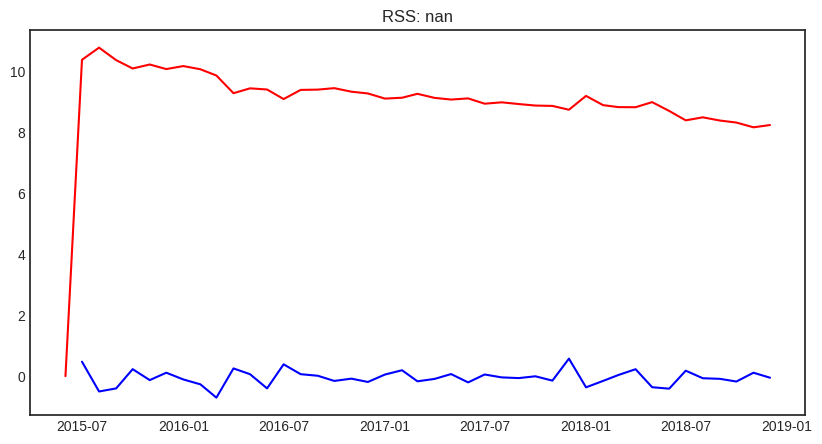

In [49]:
# Moving Average Model (p=0, d=1, q=2)
model_MA = ARIMA(ts_log, order=(0, 1, 2))
results_ARIMA_MA = model_MA.fit()
plt.figure(figsize=(10, 5))
plt.plot(ts_log_diff_active, color = 'blue')
plt.plot(results_ARIMA_MA.fittedvalues, color="red")
plt.title("RSS: %.3f" % sum((results_ARIMA_MA.fittedvalues - first_order_diff) ** 2))
plt.show()

                               SARIMAX Results                                
Dep. Variable:                    Oil   No. Observations:                   43
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  -0.130
Date:                Fri, 11 Jul 2025   AIC                             10.260
Time:                        10:27:50   BIC                             18.948
Sample:                    06-01-2015   HQIC                            13.445
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3412      0.525     -0.649      0.516      -1.371       0.689
ar.L2         -0.5342      0.478     -1.118      0.264      -1.471       0.403
ma.L1          0.1082      0.576      0.188      0.8

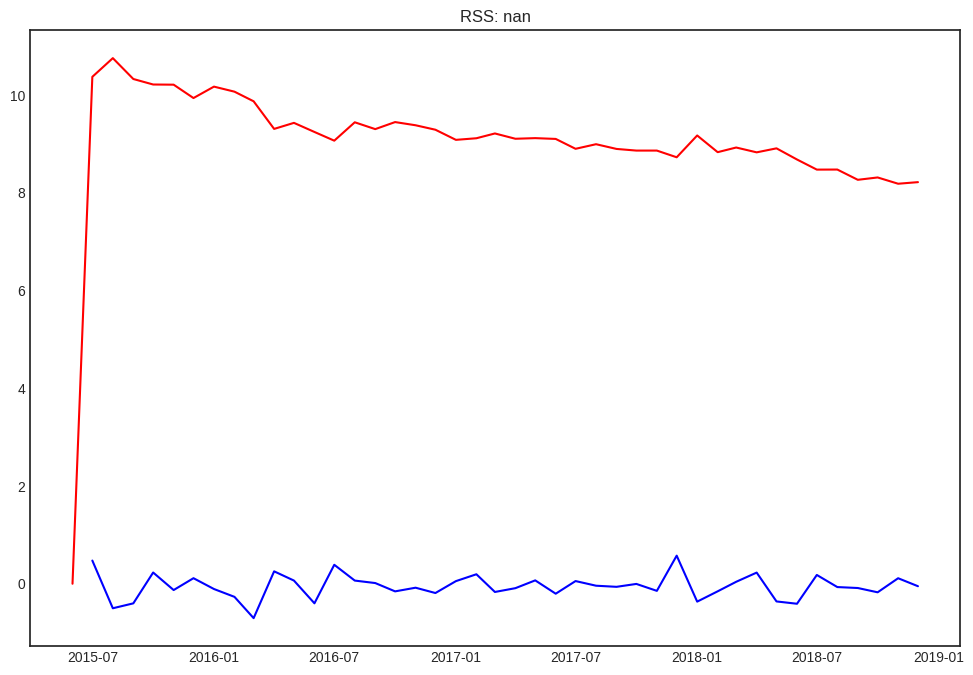

In [50]:
# Combined ARIMA model (p=2, d=1, q=2)
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit()
print(results_ARIMA.summary())
plt.plot(ts_log_diff_active, color = 'blue')
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title("RSS: %.3f" % sum((results_ARIMA.fittedvalues - first_order_diff) ** 2))
plt.show()

<Figure size 1000x500 with 0 Axes>

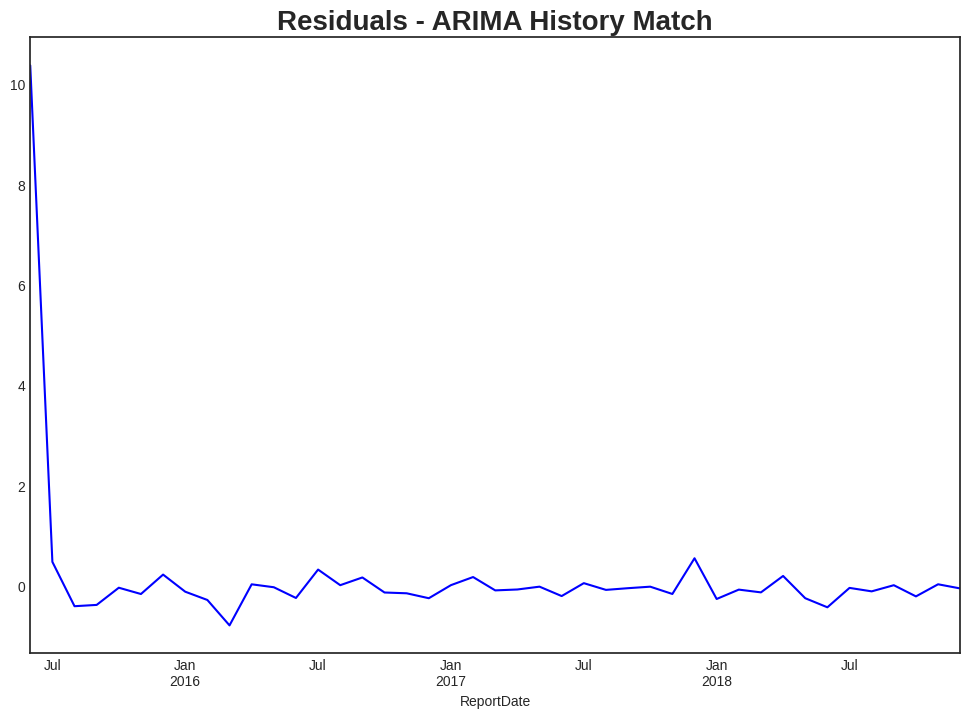

In [51]:
# residual and kde plot
plt.figure(figsize=(10, 5))# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(legend=None, color = 'blue')
plt.title('Residuals - ARIMA History Match', fontweight='bold', fontsize = 20)
plt.show()

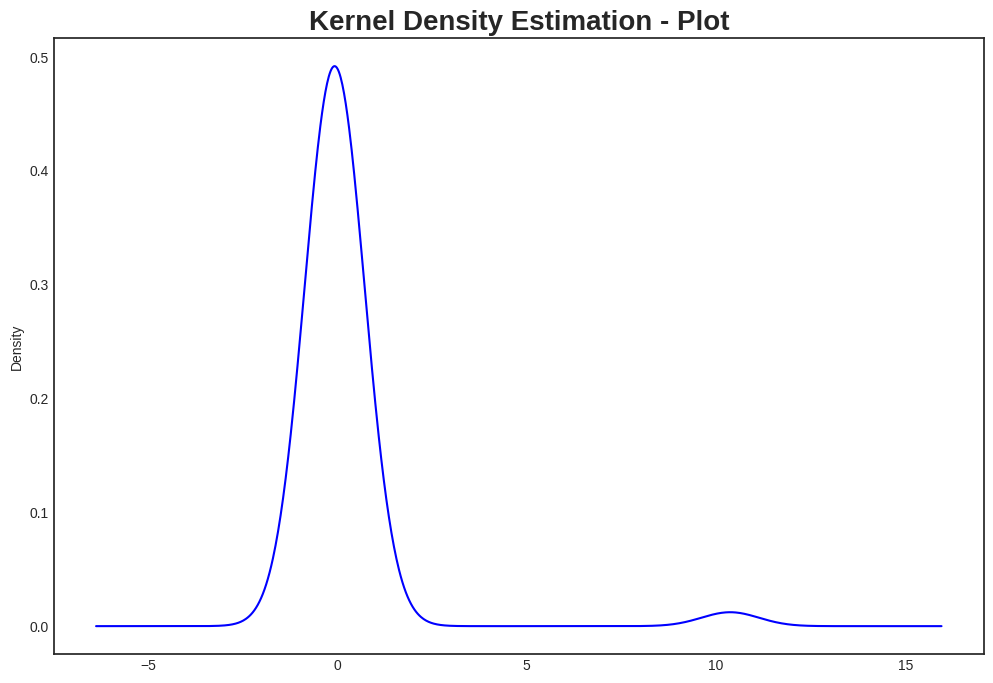

          0
count 43.00
mean   0.17
std    1.61
min   -0.79
25%   -0.19
50%   -0.08
75%    0.02
max   10.37


In [52]:
residuals.plot(kind='kde', legend=None, color = 'blue')
plt.title('Kernel Density Estimation - Plot', fontweight='bold', fontsize = 20)
plt.show()
print(residuals.describe())

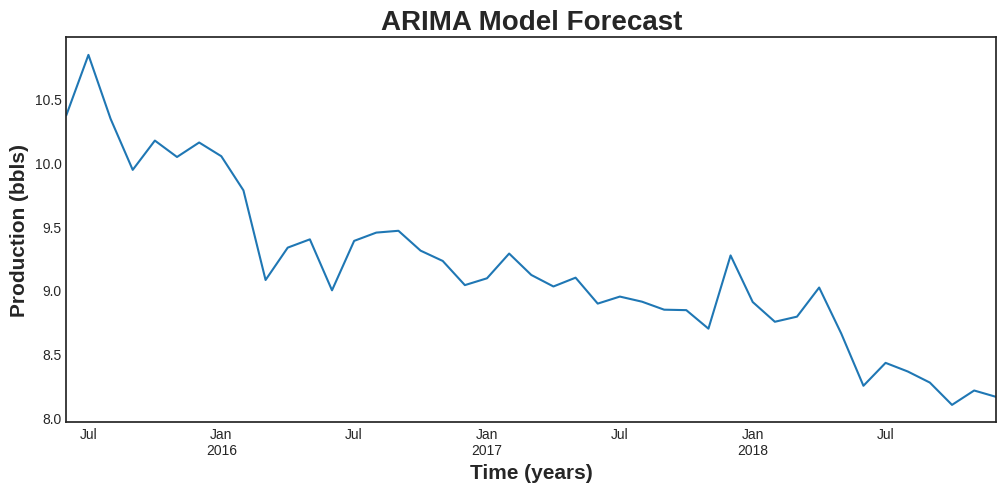

In [56]:

# forecast - ARIMA model
#results_ARIMA.plot_predict(1, 60)

# پیش‌بینی آینده (60 تا بعد از داده‌های فعلی)
forecast = results_ARIMA.get_forecast(steps=60)

# محاسبه فواصل اطمینان
pred_ci = forecast.conf_int()
predicted_mean = forecast.predicted_mean


# رسم داده‌های اصلی
ax = ts_log.plot(label='Observed', figsize=(12, 5))

# رسم مقادیر پیش‌بینی شده
#predicted_mean.plot(ax=ax, label='Forecast', color='r')

# رسم نوار اطمینان
#ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)



plt.title('ARIMA Model Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time (years)', fontweight='bold', fontsize = 15)
plt.ylabel('Production (bbls)', fontweight='bold', fontsize = 15)
plt.show()

In [67]:
# Predictions converted to right units - ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA)

ReportDate
2015-06-01                                             31919.00
2015-07-01                                        1637061449.00
2015-08-01                                    46383606501629.84
2015-09-01                                948285410891896832.00
2015-10-01                           32551893218509910441984.00
2015-11-01                       777939881065559307226972160.00
2015-12-01                  18023871383392692927000339283968.00
2016-01-01              422703289743337646219060080757702656.00
2016-02-01          7618741206772920911946351556492754157568.00
2016-03-01      72943214457935683278177834188526748476375040.00
2016-04-01   10342111798152841659354765395984685304115940556...
2016-05-01   13734393939747656536013109779619258146897103041...
2016-06-01   95101687580254068185024913420503190507779255321...
2016-07-01   12120881689191028195335196313639169632512114987...
2016-08-01   16288044737090179578919240694894385710774917232...
2016-09-01   1809250229958770

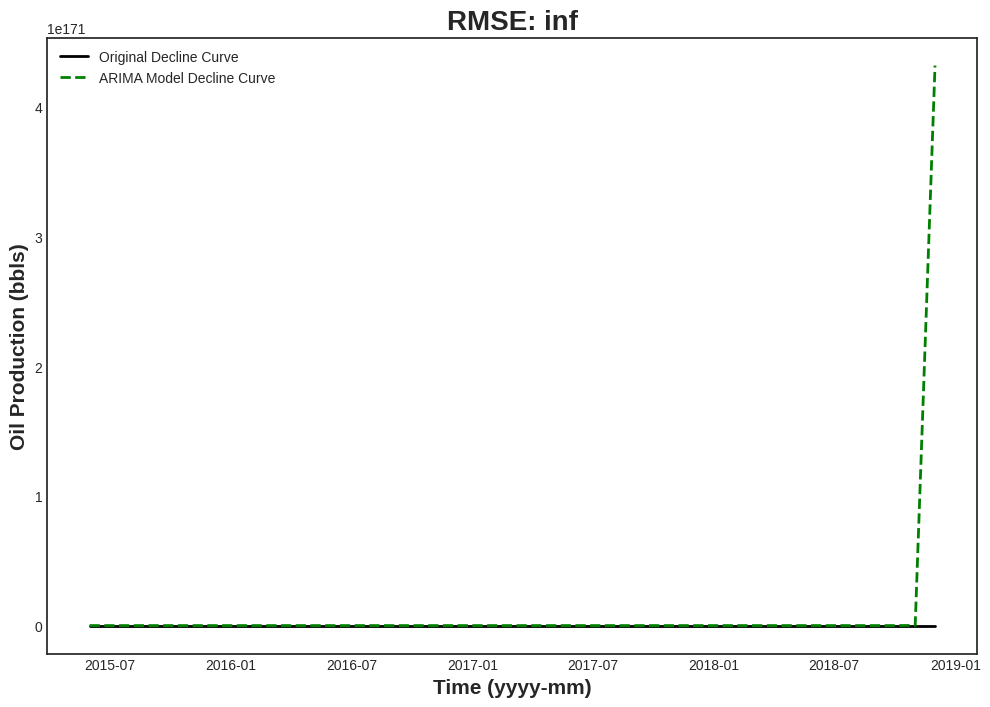

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(timeseries_train, linewidth = 2, color = 'black')
plt.plot(predictions_ARIMA, linestyle = "--", color = 'green', linewidth = 2)
plt.title("RMSE: %.3f" % np.sqrt(sum((predictions_ARIMA - timeseries_train) ** 2) / len(timeseries_train)), fontweight='bold', fontsize = 20)
plt.gca().legend(("Original Decline Curve", "ARIMA Model Decline Curve"))
plt.xlabel('Time (yyyy-mm)', fontweight='bold', fontsize = 15)
plt.ylabel('Oil Production (bbls)', fontweight='bold', fontsize = 15)
plt.show()

In [58]:
forecast = results_ARIMA.forecast(steps=12)[0]
forecast

np.float64(8.118482259515984)

In [61]:
# invert the differenced forecast results to covert to right units
X = timeseries_train.values
history = [x for x in X]
months_in_year = 12
Month = 1
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

#for yhat in forecast:
#    inverted = inverse_difference(history, yhat, months_in_year)
#    print(Month, inverted)
#    history.append(inverted)
#    Month += 1

# invert the differenced forecast result to get actual forecast
# فرض کنید forecast یک عدد float64 است (مثلاً خروجی model.get_forecast().predicted_mean[0])
inverted = inverse_difference(history, forecast, months_in_year)
print(Month, inverted)
history.append(inverted)
Month += 1



history
forecast_12_months = history[-12:] # last 12 forecasted values
predictions_ARIMA = predictions_ARIMA.to_numpy()
forecast_12_months = np.array(forecast_12_months)

1 7381.118482259516


In [62]:
print(predictions_ARIMA)
print(forecast_12_months)

[3.19190000e+004 1.63706145e+009 4.63836065e+013 9.48285411e+017
 3.25518932e+022 7.77939881e+026 1.80238714e+031 4.22703290e+035
 7.61874121e+039 7.29432145e+043 1.03421118e+048 1.37343939e+052
 9.51016876e+055 1.21208817e+060 1.62880447e+064 1.80925023e+068
 1.95795664e+072 2.13985853e+076 1.91430933e+080 1.77569141e+084
 1.95850602e+088 1.65882159e+092 1.36238586e+096 1.32933397e+100
 9.71625717e+103 7.51552772e+107 5.80699028e+111 3.98140380e+115
 2.80042287e+119 1.70937797e+123 1.86947958e+127 1.24690772e+131
 7.29709844e+134 5.70950805e+138 4.88500797e+142 2.51368611e+146
 9.81942296e+149 5.62149158e+153 2.51603407e+157 8.95276144e+160
 3.06115217e+164 1.22759955e+168 4.31996867e+171]
[6315.         6574.         8261.         5753.         3821.
 4574.         4275.         3918.         3289.         3682.
 3501.         7381.11848226]


In [63]:
arima_model_results = np.concatenate((predictions_ARIMA, forecast_12_months))
arima_model_results

array([3.19190000e+004, 1.63706145e+009, 4.63836065e+013, 9.48285411e+017,
       3.25518932e+022, 7.77939881e+026, 1.80238714e+031, 4.22703290e+035,
       7.61874121e+039, 7.29432145e+043, 1.03421118e+048, 1.37343939e+052,
       9.51016876e+055, 1.21208817e+060, 1.62880447e+064, 1.80925023e+068,
       1.95795664e+072, 2.13985853e+076, 1.91430933e+080, 1.77569141e+084,
       1.95850602e+088, 1.65882159e+092, 1.36238586e+096, 1.32933397e+100,
       9.71625717e+103, 7.51552772e+107, 5.80699028e+111, 3.98140380e+115,
       2.80042287e+119, 1.70937797e+123, 1.86947958e+127, 1.24690772e+131,
       7.29709844e+134, 5.70950805e+138, 4.88500797e+142, 2.51368611e+146,
       9.81942296e+149, 5.62149158e+153, 2.51603407e+157, 8.95276144e+160,
       3.06115217e+164, 1.22759955e+168, 4.31996867e+171, 6.31500000e+003,
       6.57400000e+003, 8.26100000e+003, 5.75300000e+003, 3.82100000e+003,
       4.57400000e+003, 4.27500000e+003, 3.91800000e+003, 3.28900000e+003,
       3.68200000e+003, 3

In [64]:
timeseries_train.values # oil rate - train
timeseries_test # oil rate - test
forecast_12_months # oil rate - forecast

ts_np = timeseries_train.to_numpy()
ts_forecast = np.array(forecast_12_months)
ts_test_np = timeseries_test.to_numpy()

actual = np.concatenate([ts_np, ts_test_np])
actual = np.delete(actual, -1)
actual

forecast = np.concatenate([predictions_ARIMA, ts_forecast])
forecast = np.delete(forecast, -1)
forecast

time = pd.date_range(start='6/1/2015', periods= 54, freq='MS')

In [65]:
rmse = sqrt(mean_squared_error(actual, forecast))
print("RMSE - ARIMA Method:", rmse)

RMSE - ARIMA Method: inf
